
# Part 2 - Multiple Hypothesis Testing with the Diabetes Dataset

## Why do we need to care if we do multiple hypothesis testing?

In Part 1, we have explored comparing 2 groups. We were able to say that they are different from each other because the p-value was below the $ \alpha $ cut-off value we set to 0.05. In simple words, the probability of seeing the effect just at random, and not a real-world effect - *a false positive* or **Type 1** error - is below 5%.

## Multiple hypothesis testing

While doing research, comparing two groups would mean our experiment was quite simple. There is nothing wrong with that, but more often you will test multiple hypotheses at the same time.

For example, you might be:
- Testing the effect of multiple different bactericidal molecules you synthesised on bacterial survival.
- Examining proteomics data trying to determine which ones out of thousands of protein levels are different between different growth conditions.
- Testing whether there is a relationship between reaction yield, and time, temperature and reagent concentration(s).

Basically, you will test multiple hypotheses when examining the same outcome.

While asking these multiple questions, the probability of a false positive result for *each question separately* is equal to the $ \alpha $ you set, usually 0.05.

However, the probability of having *at least one false positive result in the group of questions* is higher. Let's take a deeper look at this potential challenge.


## Type I Error Inflation in Multiple Testing
When you perform multiple hypothesis tests, the probability of making at least one Type I error across all tests increases. This is because each test carries its own chance of error, and the more tests you conduct, the more likely you are to encounter a false positive.

### Overall probability of at least one Type I error
If you perform *m* tests, the overall probability of making at least one Type I error is given by:

$$P(\text{at least one Type I error}) = 1 - (1 - \alpha)^m$$

where *m* is the number of tests and &alpha; is the significance level.

**Example**: For 10 tests at $\alpha = 0.05$:

$$P(\text{at least one Type I error}) = 1 - (1 - 0.05)^{10} \approx 0.401$$

This means there's about a 40% chance of making at least one false positive when conducting 10 tests with a significance level of 0.05.

The code below generates a plot showing the probability of at least Type I error depending on the number of hypotheses tested at the same time.

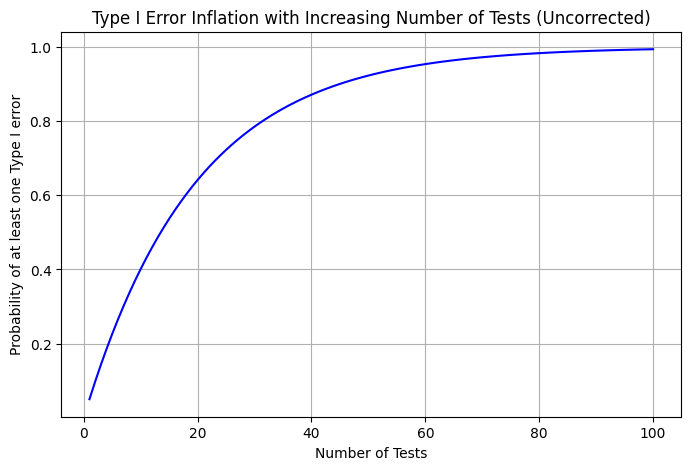

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
alpha = 0.05  # Significance level (Type I error rate for individual tests)
max_tests = 100  # Maximum number of tests to simulate

# Function to compute the probability of at least one Type I error
def probability_at_least_one_error(n_tests, alpha):
    return 1 - (1 - alpha)**n_tests

# Array of number of tests
n_tests_array = np.arange(1, max_tests + 1)

# Calculate the probability of at least one Type I error for uncorrected tests
prob_uncorrected = probability_at_least_one_error(n_tests_array, alpha)

# Plot the result
plt.figure(figsize=(8, 5))

# Plot uncorrected Type I error inflation
plt.plot(n_tests_array, prob_uncorrected, label='Uncorrected (FWER)', color='blue')

# Add labels and legend
plt.title("Type I Error Inflation with Increasing Number of Tests (Uncorrected)")
plt.xlabel("Number of Tests")
plt.ylabel("Probability of at least one Type I error")
plt.grid(True)
plt.show()

From this plot, you can appreciate that this probability can become quite high - almost a certainty. Fortunately, statisticians invented ways of dealing with this challenge, and minimizing the risk of false positives. We will discuss two of them.

### Bonferroni Correction
The **Bonferroni correction** adjusts the significance level to control the overall probability of making Type I errors when performing multiple tests. It divides the significance level by the number of tests to create a stricter threshold for each individual test.

For *m* tests, the new significance level becomes:
$$\alpha_{\text{corrected}} = \frac{\alpha}{m}$$

**Example**: If you conduct 10 tests at $\alpha = 0.05$, the Bonferroni correction adjusts the threshold for each test to $\alpha_{\text{corrected}} = 0.05 / 10 = 0.005$. This reduces the chance of making a Type I error in any given test and controls the overall error rate across all tests.

### False Discovery Rate (FDR) Correction
The **False Discovery Rate (FDR)** correction provides a more flexible approach to controlling errors in multiple testing scenarios. Instead of controlling the probability of making any false positives (like the Bonferroni correction), FDR controls the expected proportion of false positives among the rejected hypotheses. This is particularly useful when conducting a large number of tests and where some false positives are tolerable, as long as their rate is controlled.

The FDR is commonly controlled using the **Benjamini-Hochberg procedure**, although it is not the only procedure available. The steps for this procedure are as follows:

1. Rank all *p*-values in ascending order: *p<sub>1</sub>, p<sub>2</sub>, ... , p<sub>m</sub>* where *m* is the number of tests.
2. For a chosen FDR level *q*, find the largest *k* such that:
$$p_k \leq \frac{k}{m} \cdot q$$
3. Reject all hypotheses with *p*-values less than or equal to *p<sub>k</sub>*.

**Example**: If you perform 10 tests and choose an FDR level of $ q = 0.05 $, you rank the *p*-values and apply the above formula to determine the threshold for rejecting null hypotheses while controlling the FDR at 5%. This allows you to reject some hypotheses while ensuring that the proportion of false positives among them remains low.

FDR correction is generally less conservative than Bonferroni, making it more powerful in situations where multiple comparisons are being made and some false positives are acceptable.


### When to Use Bonferroni vs. FDR:

When to Use Bonferroni:

1. Small Number of Hypotheses: Bonferroni is suitable when you’re conducting only a small number of hypothesis tests (e.g., fewer than 10). In these cases, the conservativeness of Bonferroni is less of a burden, and it ensures a low risk of false positives.
2. Strong Control of Type I Errors: If you need to be extremely cautious about making false positives (e.g., in clinical trials or regulatory decision-making), Bonferroni is ideal. The focus is on ensuring that no false positives slip through, even if it means missing some true effects (i.e., increasing Type II errors).
3. Confirmatory Research: When you’re in the phase of testing well-established hypotheses, where the cost of a false positive is high, Bonferroni is preferred. For example, in medical research, where a false conclusion about a drug’s efficacy could have serious consequences, Bonferroni offers a stringent level of control.

When to Use FDR (False Discovery Rate):

1. Large Number of Hypotheses: FDR is better suited when dealing with a large number of hypotheses, such as in genomic studies, social science research, or exploratory analyses with many comparisons. In such cases, Bonferroni might be too conservative and lead to many false negatives, missing potentially important discoveries.
2. Exploratory Research: If you’re exploring many possible relationships, and your goal is to identify several potential leads while tolerating a certain proportion of false positives (e.g., identifying genes related to a disease), FDR is more appropriate. It balances discovering true effects with controlling the rate of false positives.
3. When Some False Positives Are Acceptable: In situations where false positives are less critical, and you’re willing to tolerate some in exchange for identifying more true positives, FDR is a more practical choice. This is often the case in preliminary research or in fields where follow-up studies can later validate the findings.


## Diabetes Dataset Overview

This notebook uses a subset of the **Diabetes dataset** to demonstrate multiple hypothesis testing. We will test several hypotheses about clinical measurements such as glucose levels, body mass index, and age, and then apply corrections to control for Type I errors. This dataset is often referred to as the Pima Indians Diabetes Database, as it originates from a study of diabetes among Pima Indian women in the United States.

The “diabetes” dataset is commonly used in machine learning and statistical modeling for binary classification tasks, particularly for predicting the onset of diabetes. It is publicly available and often used for educational purposes or testing models. Below is a general description of the dataset:

Key Variables (Features):

1. Pregnancies: Number of times the patient has been pregnant.
2. Glucose: Plasma glucose concentration after a 2-hour oral glucose tolerance test.
3. BloodPressure: Diastolic blood pressure (mm Hg).
4. SkinThickness: Triceps skinfold thickness (mm).
5. Insulin: 2-Hour serum insulin (mu U/ml).
6. BMI: Body mass index (weight in kg/(height in m)<sup>2</sup>).
7. DiabetesPedigreeFunction: A function which scores the likelihood of diabetes based on family history (pedigree).
8. Age: Age of the patient (years).
9. Outcome: Binary variable (0 or 1) indicating whether the patient has diabetes (1 = Yes, 0 = No).


## Hypothesis Testing and Errors
In this analysis, we will try to see which variables significantly different between the diabetic and non-diabetic patients.
Why would we do that? Each variable for which we see a significant difference could, for example, become an easy metric to monitor by doctors and be used to decide whether to send a patient for a diagnostic test to determine their diabetes status.

However, if the significant difference we reveal for a variable is due to a *Type I* error (false positive), this variable would not be a good metric to be monitored.
Therefore, we need to make sure we do not have any false positives. We'll apply both Bonferroni and False Discovery Rate (FDR) corrections to account for multiple testing and reduce Type I errors.

## Data Analysis of the diabetes dataset

### Data visualisation

As a first step of data analysis, let's visualise it. We want to test various hypotheses about how these measurements differ between diabetic and non-diabetic individuals.


In [5]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.stats.multitest import multipletests

from scipy.stats import shapiro, mannwhitneyu, ttest_ind
#from statsmodels.stats.multitest import multipletests

Loading and initial processing of data:

In [6]:
# Load the dataset
data = pd.read_csv('diabetes.csv')

# Replace 0 with NaN for relevant columns (we assume that 0 is invalid for certain variables)
# We don't consider 0 as valid for 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', and 'BMI'
columns_with_zeros = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
data[columns_with_zeros] = data[columns_with_zeros].replace(0, np.nan)

# Remove incomplete data rows
data = data.dropna()

# Separate the data by the Outcome column
diabetes_0 = data[data['Outcome'] == 0]  # No diabetes group
diabetes_1 = data[data['Outcome'] == 1]  # Diabetes group

# List of variables to plot (excluding the column, 'Outcome')
variables = data.columns[:-1]

diabetes_1

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1
6,3,78.0,50.0,32.0,88.0,31.0,0.248,26,1
8,2,197.0,70.0,45.0,543.0,30.5,0.158,53,1
13,1,189.0,60.0,23.0,846.0,30.1,0.398,59,1
14,5,166.0,72.0,19.0,175.0,25.8,0.587,51,1
16,0,118.0,84.0,47.0,230.0,45.8,0.551,31,1
19,1,115.0,70.0,30.0,96.0,34.6,0.529,32,1
24,11,143.0,94.0,33.0,146.0,36.6,0.254,51,1
25,10,125.0,70.0,26.0,115.0,31.1,0.205,41,1
31,3,158.0,76.0,36.0,245.0,31.6,0.851,28,1


Plot histograms for each variable, grouped by Outcome

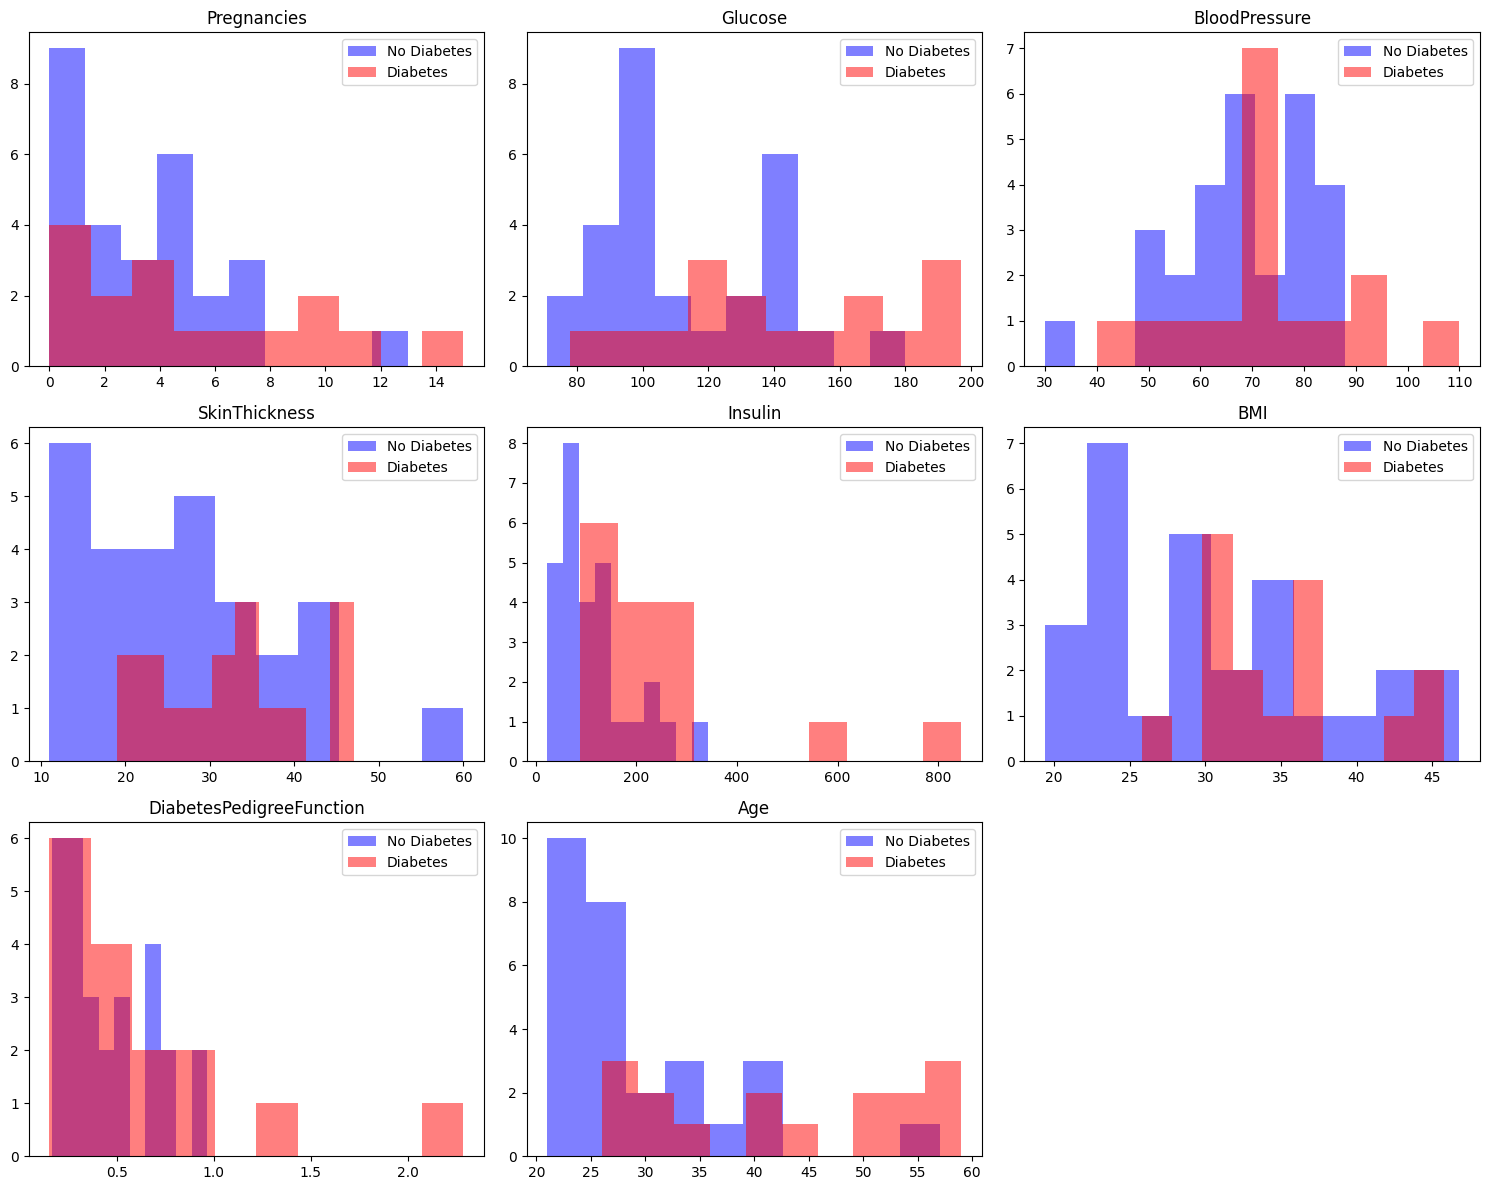

In [7]:
plt.figure(figsize=(15, 12))  # Create a figure for multiple subplots
for i, var in enumerate(variables):
    plt.subplot(3, 3, i+1)  # Create a 3x3 grid of subplots
    plt.hist(diabetes_0[var], bins=10, alpha=0.5, label='No Diabetes', color='blue')  # Plot histogram for no diabetes
    plt.hist(diabetes_1[var], bins=10, alpha=0.5, label='Diabetes', color='red')  # Plot histogram for diabetes
    plt.title(var)  # Set the title to the variable name
    plt.legend()  # Add a legend to distinguish the groups

# Display the plots
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

We can see that for all variables the distributions for people with and without diabetes *look* different. We now want to investigate if the differences are statistically significant.

### Testing if the data is nomally distributed

We want first to check if the data is normally/gaussian distributed, because that will determine if we can use the t-test or not. Some of the histograms above look normally distributed, others less so, but we should use the Shapiro-Wilk test to verify.

In [8]:
diabetes_0[variables].apply(shapiro).iloc[1]

Pregnancies                 0.002382
Glucose                     0.068130
BloodPressure               0.130857
SkinThickness               0.112857
Insulin                     0.005142
BMI                         0.104458
DiabetesPedigreeFunction    0.006678
Age                         0.000245
Name: 1, dtype: float64

The p-value is lower than 0.05 for variables: Pregnancies, Insulin, DiabetesPedigreeFunction, Age, so we reject the null hypothesis for these variables, and infer that the distributions are not normal for these variables.

How about individuals with diabetes?

In [9]:
diabetes_1[variables].apply(shapiro).iloc[1]

Pregnancies                 0.136721
Glucose                     0.773246
BloodPressure               0.397346
SkinThickness               0.456876
Insulin                     0.000387
BMI                         0.260623
DiabetesPedigreeFunction    0.001088
Age                         0.077123
Name: 1, dtype: float64

The p-value is lower than 0.05 for variables: Insulin, DiabetesPedigreeFunction, so we reject the null hypothesis for these variables, and infer that the distributions are not normal for these variables.

As some of variables are not distributed normally, we cannot use the t-test, and will use Mann-Whitney U test. Therefore, we do not need to check for equality of variance between pairs of variables.

### Hypotheses for Variables in the Diabetes Dataset

1. Pregnancies:
   - H<sub>0</sub>: The distribution of number of pregnancies is the same for people with and without diabetes.
   - H<sub>A</sub>: The distribution of number of pregnancies is different for people with and without diabetes.

2. Glucose:
   - H<sub>0</sub>: The distribution of glucose levels are the same for people with and without diabetes.
   - H<sub>A</sub>: The distribution of glucose levels are different for people with and without diabetes.

3. BloodPressure:
   - H<sub>0</sub>: The distribution of blood pressure is the same for people with and without diabetes.
   - H<sub>A</sub>: The distribution of blood pressure is different for people with and without diabetes.

4. SkinThickness:
   - H<sub>0</sub>: The distribution of skin thickness is the same for people with and without diabetes.
   - H<sub>A</sub>: The distribution of skin thickness is different for people with and without diabetes.

5. Insulin:
   - H<sub>0</sub>: The distribution of insulin levels are the same for people with and without diabetes.
   - H<sub>A</sub>: The distribution of insulin levels are different for people with and without diabetes.

6. BMI:
   - H<sub>0</sub>: The distribution of BMI is the same for people with and without diabetes.
   - H<sub>A</sub>: The distribution of BMI is different for people with and without diabetes.

7. DiabetesPedigreeFunction:
   - H<sub>0</sub>: The distribution of diabetes pedigree function is the same for people with and without diabetes.
   - H<sub>A</sub>: The distribution of diabetes pedigree function is different for people with and without diabetes.

8. Age:
   - H<sub>0</sub>: The distribution of age is the same for people with and without diabetes.
   - H<sub>A</sub>: The distribution of age is different for people with and without diabetes.

In [10]:
# Store p-values from Mann-Whitney U tests
p_values = []

# Perform Mann-Whitney U test for each variable
for var in variables:  # Exclude the Outcome column
    group_0 = diabetes_0[var].dropna()
    group_1 = diabetes_1[var].dropna()

    # Perform the test and store the p-value
    _, p_value = mannwhitneyu(group_0, group_1)
    p_values.append(p_value)

# Bonferroni correction
bonferroni_corrected = multipletests(p_values, alpha=0.05, method='bonferroni')[1]

# FDR correction (Benjamini-Hochberg)
fdr_corrected = multipletests(p_values, alpha=0.05, method='fdr_bh')[1]

# Display the original p-values, Bonferroni-corrected, and FDR-corrected p-values
print(f'{"Variable":<26} {"p-value":<14} {"Bonferroni":<15} {"FDR":<14}')
for i in range(len(variables)):
    print(f'{variables[i]:<26} {p_values[i]:<14.8f} {bonferroni_corrected[i]:<15.8f} {fdr_corrected[i]:<14.8f}')

Variable                   p-value        Bonferroni      FDR           
Pregnancies                0.32533470     1.00000000      0.41782600    
Glucose                    0.00700137     0.05601092      0.01867031    
BloodPressure              0.36559775     1.00000000      0.41782600    
SkinThickness              0.06529313     0.52234501      0.10446900    
Insulin                    0.00219392     0.01755139      0.00877569    
BMI                        0.03277272     0.26218178      0.06554544    
DiabetesPedigreeFunction   0.59988578     1.00000000      0.59988578    
Age                        0.00018397     0.00147173      0.00147173    


By carefully looking at the table, we can see that:
- The p-value for the comparison of glucose levels between the diabetic and non-diabetic populations increases over the 0.05 treshold after the Bonferroni correction, but not FDR correction
-  The p-value for the comparison of BMI between the diabetic and non-diabetic populations p-value increases over the 0.05 treshold after the Bonferroni correction, and the FDR correction.

We can also visualise these results:

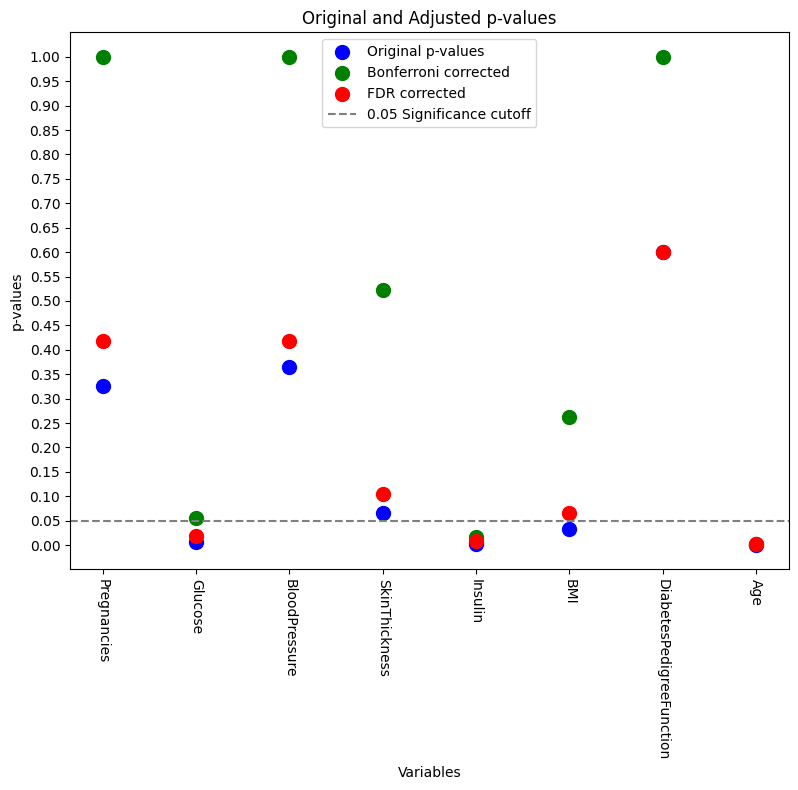

In [11]:
# Plotting the results
variables = np.array(variables)
plt.figure(figsize=(8, 8))

# Plot original p-values
plt.scatter(variables, p_values, color='blue', label='Original p-values', s=100)

# Plot Bonferroni corrected p-values
plt.scatter(variables, bonferroni_corrected, color='green', label='Bonferroni corrected', s=100)

# Plot FDR corrected p-values
plt.scatter(variables, fdr_corrected, color='red', label='FDR corrected', s=100)

# Draw the significance cutoff at p = 0.05
plt.axhline(y=0.05, color='gray', linestyle='--', label='0.05 Significance cutoff')

plt.xlabel('Variables')
plt.ylabel('p-values')
plt.title('Original and Adjusted p-values')
plt.legend(loc=9)
plt.xticks(rotation=270)
plt.tight_layout()
plt.yticks(np.arange(0, 1.05, 0.05))  # Set x-axis ticks every 0.05

# Show the plot
plt.show()

### Conclusion

Based on the statistical tests performed using the **Mann-Whitney U test**, we found significant differences in the distributions between people with and without diabetes for some of the variables considered. As do not want to not diagnose people who potentially have diabetes, we decide to use the FDR-corrected results - which are less strict. Below is a summary of the findings:

1. **Glucose**: The distribution of glucose levels is significantly different between people with and without diabetes.

2. **Insulin**: The distribution of insulin levels is significantly different between people with and without diabetes.

3. **Age**: The distribution of age is significantly different between people with and without diabetes.

For all other variables considered in this analysis we could not find a significant difference. That does not mean the difference does not exist - perhaps it is just that our data is not sufficient to show it.

### Practice - Analysis of the full diabetes dataset

The dataset explored above was just a subset of the full diabetes dataset. Imagine that more data has been collected since, and you can now repeat the same analysis.

You can find the full dataset in the diabetes_full.csv file.